## ######Backtester is fine here 

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from pymongo import MongoClient
import datetime
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from talib import abstract

from functools import partial

In [37]:
#Download Data from yahoo
### TEST Scnarios - TCS- Bull ,ACC- modrate up (Sidewase),YESBank- Back to Zero ,ITC(stock dosnt even Move)
stock='TCS'
startdate='2007-01-01'
enddate='2022-01-01'
exchange=['.NS','.BO']
dfo = yf.download(stock+exchange[0],start=startdate)

[*********************100%***********************]  1 of 1 completed


In [73]:

# To calculate Rolling weighted expontional moving average. alpha being used is 1/<moving average period>. You can play with alpha between 1-0  
# This will give me three thing 
#1. will Return Rolling Moving Average for the given period .Also will revove the rows where rolling MA value is NA .
#2. Will calcuate how many consicutive days price traded above or below Rolling MA.
#3. Will calculate how far price travlled (up or down )in term of % from Rolling moving Average .If % change is -ve means price moved below RMA otherwise above RMA.

##################### Here you can play with Windows and alpha ##########
def rwema(window,df,field):

    alpha=1/window
    weights=list(reversed([(1-alpha)**n for n in range(window)]))
    ewma = partial(np.average, weights=weights)
    df['RWEMA'] = df[field].rolling(window).apply(ewma)

    df.dropna(inplace=True)
    ##########TO check how much  moving up or down from given point 
    upcount =0
    upcum_change=0
    dcount =0
    dcum_change=0
    upbase=[]
    dbase=[]
    first_trade=0
    df['cum_above_0'] = 0
    df['cum_above_pct_change'] = 0
    df['cum_below_0'] = 0
    df['cum_below_pct_change'] = 0
    for index, row in df.iterrows():
        if ((row[field]>row['RWEMA']) & (df[field].shift(1)[index]< row['RWEMA'])) | ((row[field]<row['RWEMA']) & (df[field].shift(1)[index]> row['RWEMA'])):
            first_trade=1

        if first_trade==1:

            if  row[field] > row['RWEMA'] :
                dcount =0
                dcum_change=0
                dbase.clear()
                upbase.append(row[field])
                upcount += 1
                upcum_change=((row[field]-upbase[0])/upbase[0])*100
                df.loc[index, 'cum_above_0'] = upcount
                df.loc[index, 'cum_above_pct_change'] = upcum_change
                # cum_change=cum_change+row['pct_change']

            elif row[field] < row['RWEMA']:
                upcount =0
                upcum_change=0
                upbase.clear()
                dbase.append(row[field])
                dcount -= 1
                dcum_change=((row[field]-dbase[0])/dbase[0])*100
                df.loc[index, 'cum_below_0'] = dcount
                df.loc[index, 'cum_below_pct_change'] = dcum_change

    df['RWEMA_movement']=df['cum_above_0']+df['cum_below_0']
    df['RWEMA_price%movement']=df['cum_above_pct_change']+df['cum_below_pct_change']
    df.drop('cum_above_0',axis=1,inplace=True)
    df.drop('cum_below_0',axis=1,inplace=True)
    df.drop('cum_above_pct_change',axis=1,inplace=True)
    df.drop('cum_below_pct_change',axis=1,inplace=True)
    #To mark all rows when its above (1) or below (-1) from first day.it will be 0 if price didnt crossed in either of direction.
    # 1 will represent price trading above ma ,-1 will tell price trading below MA (after intial trade happned)
    df['check']=np.where((df['RWEMA_movement']>0),1,np.where((df['RWEMA_movement']<0),-1,0))
    return df

In [75]:
df

,Open,High,Low,Close,Adj Close,Volume,pct_change,RWEMA,RWEMA_movement,RWEMA_price%movement,check
Date,,,,,,,,,,,
2008-01-07,250.000000,252.199997,243.125000,243.899994,186.840500,3647344,-2.944691,280.296451,0,0.000000,0
2008-01-08,245.000000,248.000000,242.324997,246.962494,189.186447,3207732,1.255638,279.995941,0,0.000000,0
2008-01-09,248.699997,251.500000,247.475006,249.074997,190.804794,2450128,0.855394,279.722015,0,0.000000,0
2008-01-10,249.500000,252.375000,240.500000,245.412506,187.999191,3342376,-1.470437,279.423936,0,0.000000,0
2008-01-11,228.837494,251.000000,228.837494,247.437500,189.550385,2149188,0.825139,279.150789,0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...
2022-02-04,3815.300049,3824.699951,3769.000000,3814.899902,3814.899902,2307366,-0.253626,3484.246277,404,80.045767,1
2022-02-07,3791.000000,3831.800049,3756.149902,3779.000000,3779.000000,1919149,-0.941044,3486.888523,405,78.351456,1
2022-02-08,3791.550049,3799.699951,3721.000000,3743.449951,3743.449951,2946443,-0.940726,3489.149801,406,76.673657,1


## First Output
### SkewNess based on total Number of Days Trading above or below MA .
#### +ve Skew number means ,Price traded above MA for that much % of time .
#### -ve Skew number means ,Price traded below MA for that much % of time .

In [28]:
def days_skew(df):
    skew_data=df.groupby(df['check'])['RWEMA_movement'].count()
    skew_data=skew_data.to_frame()
    ## maximum total -ve Days
    neg=skew_data.loc[skew_data.index<0].max()[0]
    ## maximum total +ve Days
    pos=skew_data.loc[skew_data.index>0].max()[0]

    ## % MA Skew
    skew=((pos-neg)/(pos+neg))*100
    skew=round(skew,2)
    print(f"Number of days above MA  {pos}")
    print(f"Number of days below MA {neg}")
    print(f"This Stock haing postive MA Skew of {skew}% for MV 250 ")
    return skew

In [40]:
skew=days_skew(df=df)

Number of days above MA  2620
Number of days below MA 759
This Stock haing postive MA Skew of 55.08% for MV 250 


## 2nd Output
### Days to wait before Entering in trade based on % price reached to nex day .
#### In put variable to play with . % value when price reached to particular day . keep it >85<91
#### pass in df  it will create new dataframe nsame as df2 .

In [41]:
########### Here We are Calculating How Many Times Price Touched Specfic number of Days.
# +Days means price was trading above MA
# -Ve means Proce was trading below MA 
def best_wait_period(df,minpass):
    data=df.groupby(df['RWEMA_movement']).Close.count()
    df2=data.to_frame()
    df2.reset_index(inplace=True)
    df2.rename(columns={'RWEMA_movement':'#Days','Close':'#Times_Approched'},inplace=True)
    df2.set_index('#Days',inplace=True)
    ################ Segrigated Main Stage 2 DF(df2) to two df's .One for when price crossed up and traded above, and other one when price crossed below and traded below  
    df2_up=df2.loc[df2.index>0]
    df2_down=df2.loc[df2.index<0]
    df2_down=df2_down.iloc[::-1]
    ########This Section will merge the up and down df's into one and will add coluns acc to up days and down days .
    df2_up_temp=df2_up.copy()
    df2_up_temp.reset_index(inplace=True)
    df2_up_temp.rename(columns={'#Times_Approched':'#Times_Approched_UP'},inplace=True)

    df2_down_temp=df2_down.copy()
    df2_down_temp.reset_index(inplace=True)
    df2_down_temp['#Days']=df2_down_temp['#Days'].abs()
    df2_down_temp.rename(columns={'#Times_Approched':'#Times_Approched_DOWN'},inplace=True)

    df2_tmp=df2_up_temp.merge(df2_down_temp,on='#Days',how='outer')
    df2_tmp.replace(to_replace=np.nan,value=0,inplace=True)

    df2_tmp=df2_tmp.astype(int)

    df2_tmp.set_index('#Days',inplace=True)
    ### Will calculate % Chances that price will reach to that particuler day from previous day 
    #85% (in case of adjusted price ) and >90% (in case of Closed Price) is number to look . 
    # df2_tmp['%Chance_toApproched_UP']=(df2_tmp['#Times_Approched_UP']/df2_tmp['#Times_Approched_UP'].max())*100
    df2_tmp['%Crossed_UP']=(df2_tmp['#Times_Approched_UP']/df2_tmp['#Times_Approched_UP'].shift(1))*100
    # df2_tmp['%Crossed_UP_t']=(1-(df2_tmp['#Times_Approched_UP']/df2_tmp['#Times_Approched_UP'].shift(1)))*100


    # df2_tmp['%Chance_toApproched_DOWN']=(df2_tmp['#Times_Approched_DOWN']/df2_tmp['#Times_Approched_DOWN'].max())*100
    df2_tmp['%Crossed_DOWN']=(df2_tmp['#Times_Approched_DOWN']/df2_tmp['#Times_Approched_DOWN'].shift(1))*100
    # df2_tmp['%Crossed_DOWN_t']=(1-(df2_tmp['#Times_Approched_DOWN']/df2_tmp['#Times_Approched_DOWN'].shift(1)))*100

    ##### Checking how many days it takes up or down side when price crossed up or down and more then 90% chances that it will continue in same direction.
    ## Just change the % to check if you want it more consistant .but best to keep above 85 and below 91% for best risk reward. .
    min_days_up=df2_tmp.loc[df2_tmp['%Crossed_UP']>=minpass][:1].index[0]
    min_days_down=df2_tmp.loc[df2_tmp['%Crossed_DOWN']>=minpass][:1].index[0]
    print(f"when crossed above ,wait for {min_days_up} days. \nwhen crossed below ,wait for {min_days_down} days")
    return min_days_up,min_days_down


In [42]:
min_days_up,min_days_down=best_wait_period(df,90)

when crossed above ,wait for 6 days. 
when crossed below ,wait for 5 days


## 3rd Output
### Next Step is to find % Average gain w.r.t #Days when crossing Above or Down .

#### Input will be df and outbut will be new dataframe df3

In [43]:
## Taking mean of % change of price when crossed up or down for specfic days 
def best_wait_period_gain_based(df,mingain):
    data1=df.groupby(df['RWEMA_movement'])['RWEMA_price%movement'].mean()
    df3=data1.to_frame()
    df3.reset_index(inplace=True)
    df3.rename(columns={'RWEMA_movement':'#Days','RWEMA_price%movement':'% Average Price Move'},inplace=True)
    df3.set_index('#Days',inplace=True)
    # ####### Genric Information 
    # print(f"maximum number of Consicutive days traded downside is {abs(df3.head(1).index[0])}")
    # print(f"maximum number of Consicutive days traded upside is {abs(df3.tail(1).index[0])}")
    # print (f"price moved {round(((abs(df3.tail(1).index[0])-abs(df3.head(1).index[0]))/(df3.index.max())*100),2)} % more consicutive days towards up side compare to downside")

    ### Segrigated Main Stage 3 DF(df3) to two df's .One for when price crossed up and traded above, and other one when price crossed below and traded below  
    df3_up=df3.loc[df3.index>0]
    df3_down=df3.loc[df3.index<0]

    # Reversing the dataframe
    df3_down=df3_down.iloc[::-1]

    #This Section will merge the up and down df's into one and will add coluns acc to up days and down days .
    df3_up_temp=df3_up.copy()
    df3_up_temp.reset_index(inplace=True)
    df3_up_temp.rename(columns={'% Average Price Move':'%Avg Price Move UP'},inplace=True)

    df3_down_temp=df3_down.copy()
    df3_down_temp.reset_index(inplace=True)
    df3_down_temp['#Days']=df3_down_temp['#Days'].abs()
    df3_down_temp.rename(columns={'% Average Price Move':'%Avg Price Move DOWN'},inplace=True)

    df3_tmp=df3_up_temp.merge(df3_down_temp,on='#Days',how='outer')
    df3_tmp.replace(to_replace=np.nan,value=0,inplace=True)

    # df2_tmp=df2_tmp.astype(int)

    df3_tmp.set_index('#Days',inplace=True)

    ### Checking how much % gain  for specfic number of days 
    ### Just change the % to check if you want it more consistant .but best to keep above 1.5% and below 91% for best risk reward. .
    min_days_g_up=df3_tmp.loc[df3_tmp['%Avg Price Move UP']>=mingain][:1].index[0]
    min_days_g_down=df3_tmp.loc[df3_tmp['%Avg Price Move DOWN']<=mingain*(-1)][:1].index[0]
    print(f"when crossed above ,wait for {min_days_g_up} days. \nwhen crossed below ,wait for {min_days_g_down} days.\nThis is based on min gain of {mingain}%")
    return min_days_g_up,min_days_g_down

In [44]:
min_days_g_up,min_days_g_down=best_wait_period_gain_based(df,1.5)

when crossed above ,wait for 4 days. 
when crossed below ,wait for 4 days.
This is based on min gain of 1.5%


In [82]:
def backtester(start,end,init_df,trade_type,ma):
    bt=pd.DataFrame({'StartDate':start,'EndDate':end})
    bt.replace(to_replace=np.nan,value=0,inplace=True)
    
    dataframes=[]
    pc_=[]
    
    if trade_type=='long':
        
        for index in bt.index:
            init_df_tmp=(init_df.loc[(init_df.index>=bt['StartDate'][index]) & (init_df.index<=bt['EndDate'][index])]).copy()
            ## Setting up Default Variables
            pos=0
            num=0
            percentchange=[]
            day_count=0
            init_df_tmp['pos_days']=0
            init_df_tmp['s_daily_change']=0.0
            s_st=[]
            trigger_p=[]
            lastpc=[0,]
            
            trade_start=0
            #### price at time of start date of this stratgy
            u_st=init_df_tmp['Close'][0]
            
            for i in init_df_tmp.index:
                CP=init_df_tmp['Close'][i]
                # Underline Daily return from the start date of Stratgy 
                init_df_tmp.at[i,'u_daily_Return']=init_df_tmp['pct_change'][i]
                
                if i != init_df_tmp.index[0]:

                    #############Conditions######################
                    #############Long Position###################
                    long_condition=(init_df_tmp['Close'][i]> init_df_tmp['RWEMA'][i]) & (init_df_tmp['Close'].shift(1)[i]< init_df_tmp['RWEMA'][i])
                    #############Short Postion###################
                    short_condition=(init_df_tmp['Close'][i]< init_df_tmp['RWEMA'][i]) & (init_df_tmp['Close'].shift(1)[i]> init_df_tmp['RWEMA'][i])
                    #############Long SL/Exit#########################
                    long_exit=(init_df_tmp['Close'][i]< init_df_tmp['RWEMA'][i]) & (init_df_tmp['Close'].shift(1)[i]> init_df_tmp['RWEMA'][i])
                    #############Short SL/Exit#########################
                    short_exit=(init_df_tmp['Close'][i]> init_df_tmp['RWEMA'][i]) & (init_df_tmp['Close'].shift(1)[i]< init_df_tmp['RWEMA'][i])
                  
                    
                    ## Enter into Long
                    if not s_st:
                        if long_condition:                
                            if(pos==0):
                                print("Long Buy Triggred")
                                bp=CP
                                pos=1
                                print("Buying now at "+str(bp))
                                init_df_tmp.at[i,'pos_days']=day_count
                                if not s_st: # to check if any long or short position already triggred or not. if s_st have value ,means already atleast one trade happned.
                                    s_st.append(bp)
                    else:
                        if(pos==1):
                            day_count+=1
                            init_df_tmp.at[i,'pos_days']=day_count
                            init_df_tmp.at[i,'s_daily_change']=init_df_tmp['pct_change'][i]

                    ## Long SL/Exit       
                    if long_exit:                
                        if(pos==1):
                            print("Long Covering Triggred")
                            day_count=0
                            pos=0
                            sp=CP
                            print("Existing now at "+str(sp))
                            pc=(sp/bp-1)*100
                            percentchange.append(pc)
                            init_df_tmp.at[i,'pos_days']=day_count
                            s_st.clear()


                    if(num==init_df_tmp["Close"].count()-1 and pos==1):
                        pos=0
                        sp=CP
                        day_count=0
                        print("Existing now at "+str(sp))
                        pc=(sp/bp-1)*100
                        percentchange.append(pc)
                        init_df_tmp.at[i,'pos_days']=day_count
                        s_st.clear()


                    num+=1    
                pc_.append(percentchange)

                #################################for Performance Matrix############
                # Stratgy Cummulative returns and Underline Cummulative returns
                init_df_tmp['scr']=((1+(init_df_tmp['s_daily_change']/100)).cumprod()-1)*100
                init_df_tmp['ucr']=((1+(init_df_tmp['u_daily_Return']/100)).cumprod()-1)*100        
                
                gains=0
                ng=0
                losses=0
                nl=0
                for i in percentchange:
                    if(i>0):
                        gains+=i
                        ng+=1
                    else:
                        losses+=i
                        nl+=1

                if(ng>0):
                    avgGain=gains/ng
                    maxR=max(percentchange)
                else:
                    avgGain=0
                    maxR=0

                if(nl>0):
                    avgLoss=losses/nl
                    maxL=min(percentchange)
                    ratio=-avgGain/avgLoss
                else:
                    avgLoss=0
                    maxL=0
                    ratio=999

                if(ng>0 or nl>0):
                    battingAvg=(ng/(ng+nl))*100
                else:
                    battingAvg=0
                ### Adding matrix to BackTEST Dataframe#####
                bt.at[index,'MA']=ma
                bt.at[index,'#Trades']=ng+nl
                bt.at[index,'Win avg']=round(battingAvg,2)
                bt.at[index,'#Wins']=ng
                bt.at[index,'#loss']=nl
                bt.at[index,'Gain/loss ratio']=round(ratio,2)
                bt.at[index,'Average Gain %']=round(avgGain,2)
                bt.at[index,'Average Loss %']=round(avgLoss,2)
                bt.at[index,'Max Return %']=round(maxR,2)
                bt.at[index,'Max Loss %']=round(maxL,2)
                bt.at[index,'Stratergy-Cum Total return %']=round(init_df_tmp['scr'][-1],2)
                bt.at[index,'Underline-Cum Total return %']=round(init_df_tmp['ucr'][-1],2)

                ## Adding Result Dataframe into List of Dataframes
                dataframes.append(init_df_tmp)
                
    return bt#
    
    

In [91]:
windows=list(range(200,300))
results=pd.DataFrame()

for i in windows:
    ## Making Copy of Dataframe for further analysis and changes
    df=dfo.copy()
    # Adding feild called % Daily changes out of 100%
    df['pct_change']=(df['Close'].pct_change())*100
    df.dropna(inplace=True)

    #### Calling REMA
        #10 for week , 21 days a week -->53 days
    field='Close'
    window=i
    df=rwema(window,df,field)

    ###########Full
    # start and end must be same length
    start=['2008-01-07']
    end=['2022-02-01']

    # pc,init_df=backtest(start=start,end=end,init_df=df)
    result_matrix_f=backtester(start=start,end=end,init_df=df,trade_type='long',ma=i)
    results=pd.concat([results,result_matrix_f],axis=0)

Long Buy Triggred
Buying now at 250.22500610351562
Long Covering Triggred
Existing now at 221.8000030517578
Long Buy Triggred
Buying now at 241.6875
Long Covering Triggred
Existing now at 236.75
Long Buy Triggred
Buying now at 242.78750610351562
Long Covering Triggred
Existing now at 239.02499389648438
Long Buy Triggred
Buying now at 241.27499389648438
Long Covering Triggred
Existing now at 233.10000610351562
Long Buy Triggred
Buying now at 242.22500610351562
Long Covering Triggred
Existing now at 228.52499389648438
Long Buy Triggred
Buying now at 151.03750610351562
Long Covering Triggred
Existing now at 148.0625
Long Buy Triggred
Buying now at 150.47500610351562
Long Covering Triggred
Existing now at 349.7749938964844
Long Buy Triggred
Buying now at 369.0
Long Covering Triggred
Existing now at 366.0
Long Buy Triggred
Buying now at 371.8999938964844
Long Covering Triggred
Existing now at 554.5999755859375
Long Buy Triggred
Buying now at 568.875
Long Covering Triggred
Existing now at 56

In [94]:
results

,StartDate,EndDate,MA,#Trades,Win avg,#Wins,#loss,Gain/loss ratio,Average Gain %,Average Loss %,Max Return %,Max Loss %,Stratergy-Cum Total return %,Underline-Cum Total return %
0,2008-01-07,2022-02-01,200.0,67.0,17.91,12.0,55.0,11.90,24.99,-2.10,132.45,-11.36,430.86,1412.40
0,2008-01-07,2022-02-01,201.0,67.0,16.42,11.0,56.0,13.54,27.21,-2.01,132.45,-11.36,444.02,1412.40
0,2008-01-07,2022-02-01,202.0,65.0,20.00,13.0,52.0,11.28,23.27,-2.06,132.45,-11.36,488.22,1412.40
0,2008-01-07,2022-02-01,203.0,67.0,16.42,11.0,56.0,13.37,26.62,-1.99,132.45,-11.36,423.56,1412.40
0,2008-01-07,2022-02-01,204.0,66.0,16.67,11.0,55.0,13.28,26.62,-2.00,132.45,-11.36,430.19,1412.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2008-01-07,2022-02-01,295.0,47.0,12.77,6.0,41.0,30.73,64.06,-2.08,219.04,-12.96,701.89,1636.84
0,2008-01-07,2022-02-01,296.0,46.0,10.87,5.0,41.0,37.41,77.40,-2.07,219.04,-12.96,716.53,1696.68
0,2008-01-07,2022-02-01,297.0,47.0,12.77,6.0,41.0,31.01,64.57,-2.08,219.04,-12.96,715.51,1723.62
0,2008-01-07,2022-02-01,298.0,46.0,10.87,5.0,41.0,36.66,77.40,-2.11,219.04,-12.96,702.24,1746.10


In [98]:
results['s/u']=round(results['Stratergy-Cum Total return %']/results['Underline-Cum Total return %'],2)

In [ ]:
results[['MA','Win avg','Stratergy-Cum Total return %','Underline-Cum Total return %','s/u']]

In [102]:
import mitosheet
mitosheet.sheet(results[['MA','Win avg','Stratergy-Cum Total return %','Underline-Cum Total return %','s/u']], view_df=True)

MitoWidget(analysis_data_json='{"analysisName": "UUID-6b4579c5-b88d-4809-90dd-8670a7c2783b", "code": {"imports…

In [ ]:
# MITO CODE START (DO NOT EDIT)

from mitosheet import * # Import necessary functions from Mito
register_analysis('UUID-6b4579c5-b88d-4809-90dd-8670a7c2783b') # Let Mito know which analysis is being run

# Sorted s/u in results[['MA' in ascending order
results[['MA' = results[['MA'.sort_values(by='s/u', ascending=True, na_position='first')

  
# MITO CODE END (DO NOT EDIT)

MitoWidget(analysis_data_json='{"analysisName": "UUID-56197230-607f-4fbe-95cd-660830742f17", "code": {"imports…

In [49]:
init_df_matrix_f=init_df_matrix_f[0]

In [18]:
# init_df_matrix_f.to_csv('resutls1.csv')

In [19]:
init_df_matrix_f.loc[init_df_matrix_f.index>='2010-09-10']

,Open,High,Low,Close,Adj Close,Volume,pct_change,RWEMA_252,RWEMA_252_movement,RWEMA_252_price%movement,check,pos_days,s_daily_change,u_daily_Return,scr,ucr
Date,,,,,,,,,,,,,,,,
2010-09-13,981.299988,1016.849976,981.299988,990.450012,817.570618,586932,0.973594,866.376137,17,12.124304,1,16,0.973594,0.973594,53.674368,-0.920323
2010-09-14,991.000000,993.000000,966.650024,970.049988,800.731384,310699,-2.059672,867.195717,18,9.814911,1,17,-2.059672,-2.059672,50.509180,-2.961040
2010-09-15,972.900024,985.000000,954.000000,960.400024,792.765747,421615,-0.994790,867.934845,19,8.722483,1,18,-0.994790,-0.994790,49.011929,-3.926374
2010-09-16,959.650024,974.849976,950.000000,965.700012,797.140503,376116,0.551852,868.713252,20,9.322470,1,19,0.551852,0.551852,49.834254,-3.396190
2010-09-17,968.599976,1003.000000,968.599976,997.849976,823.678955,960077,3.329187,869.689128,21,12.962020,1,20,3.329187,3.329187,54.822518,-0.180068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-25,2160.100098,2192.600098,2120.050049,2179.949951,2179.949951,262179,0.576715,2166.188048,22,2.024149,1,21,0.576715,0.576715,63.974919,118.071315
2022-01-27,2156.000000,2179.000000,2127.649902,2167.699951,2167.699951,298193,-0.561940,2167.247640,23,1.450835,1,22,-0.561940,-0.561940,63.053479,116.845886
2022-01-28,2179.899902,2238.550049,2173.850098,2215.949951,2215.949951,272371,2.225862,2168.707561,24,3.708991,1,23,2.225862,2.225862,66.682824,121.672575


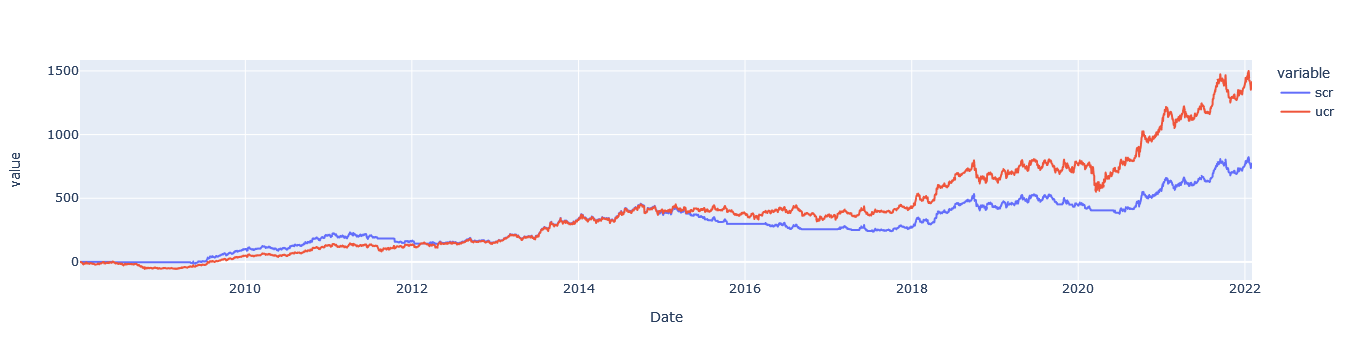

In [50]:
fig=px.line(init_df_matrix_f[['scr','ucr']],)
fig.show()

In [21]:
# pc=pc[0]

In [22]:
# totalR=1.0
# gains=0
# ng=0
# losses=0
# nl=0
# for i in pc:
#     if(i>0):
#         gains+=i
#         ng+=1
#     else:
#         losses+=i
#         nl+=1
#     totalR=totalR*((i/100)+1)

# totalR=round((totalR-1)*100,2)
# print(totalR)

60.72
